In [1]:
# Cell 0: PyTorch CUDA Configuration (Place this at the very top of your notebook)
# This helps with memory management on the GPU.
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print("CUDA memory config set.")

CUDA memory config set.


In [2]:
#Cell 1
# Install required packages quietly
!pip install -q "transformers>=4.41.2" accelerate bitsandbytes sentencepiece pillow kagglehub torch einops scipy

print("✅ Installed dependencies.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 21.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.8 MB/s eta 0:00:00:00:0100:01
✅ Installed de

In [3]:
#Cell 2
from huggingface_hub import login

try:
    print("🔐 Login to Hugging Face (get your token from https://huggingface.co/settings/tokens)")
    login()
except Exception as e:
    print("❌ Login failed:", e)


🔐 Login to Hugging Face (get your token from https://huggingface.co/settings/tokens)


In [4]:
#Cell 3
import pandas as pd

# Use correct Kaggle input paths (assuming dataset is added in "Data" section of notebook)
STYLES_CSV = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"
IMAGES_DIR = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

# Load the CSV, skipping bad lines
df = pd.read_csv(STYLES_CSV, on_bad_lines='skip')
print(f"✅ Loaded styles.csv: {df.shape}")


✅ Loaded styles.csv: (44424, 10)


In [5]:
#Cell 4
import os

# Remove rows with missing values
df_cleaned = df.dropna(subset=["productDisplayName", "articleType"]).copy()

# Remove irrelevant articles (cosmetics, non-wearables, etc.)
irrelevant = [
    "Fragrance", "Deodorant", "Nail Polish", "Lipstick", "Compact", "Eye Shadow", "Mascara",
    "Foundation", "Jewellery", "Wallets", "Hair Accessory", "Earrings", "Shoe accessories"
]
df_cleaned = df_cleaned[~df_cleaned['articleType'].isin(irrelevant)]

# Filter for existing image files
existing_ids = {f.split(".")[0] for f in os.listdir(IMAGES_DIR) if f.endswith(".jpg")}
df_cleaned = df_cleaned[df_cleaned['id'].astype(str).isin(existing_ids)].reset_index(drop=True)

print(f"✅ Cleaned data: {df_cleaned.shape}")
df_cleaned.head()


✅ Cleaned data: (42006, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


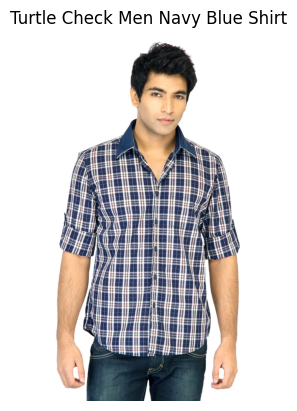

gender                  Men
masterCategory      Apparel
subCategory         Topwear
articleType          Shirts
baseColour        Navy Blue
Name: 0, dtype: object


In [6]:
#Cell 5
import matplotlib.pyplot as plt
from PIL import Image

def show_sample(index=0):
    row = df_cleaned.iloc[index]
    img_path = os.path.join(IMAGES_DIR, f"{int(row['id'])}.jpg")
    img = Image.open(img_path)

    plt.imshow(img)
    plt.axis("off")
    plt.title(row['productDisplayName'])
    plt.show()
    print(row[['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour']])

show_sample(0)


In [7]:
#Cell 6
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch

model_name = "llava-hf/llava-1.5-7b-hf"  # Change this if using another VLM

# Load processor and model
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)

print("✅ VLM model and processor loaded.")


2025-07-30 04:27:50.240562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753849670.450242      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753849670.510273      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

✅ VLM model and processor loaded.


In [11]:
#Cell 7
from PIL import Image
import torch

def generate_caption(image_path, prompt=None):
    image = Image.open(image_path).convert("RGB")

    # Enhanced, detailed prompt
    if prompt is None:
        prompt = (
            "<image> Describe this clothing item in detail. "
            "Include dress type, visible colors, sleeve length, pattern, fabric, neckline, occasion, and gender."
        )

    # Preprocess image and text
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)

    # Generate caption
    output_ids = model.generate(
        **inputs,
        max_new_tokens=150,          # ⬅️ INCREASE FROM DEFAULT (often 20–50)
        temperature=0.8,             # ⬅️ Increase randomness to allow longer answers
        top_p=0.95,                  # ⬅️ Common setting for diverse generation
        do_sample=True               # ⬅️ Allow sampling for better variation
    )
    caption = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    return caption

# Run it
sample_id = df_cleaned.iloc[0]['id']
img_path = os.path.join(IMAGES_DIR, f"{int(sample_id)}.jpg")
print("🧠 Model Output:", generate_caption(img_path))


🧠 Model Output: Describe this clothing item in detail. Include dress type, visible colors, sleeve length, pattern, fabric, neckline, occasion, and gender.

The shirt on the man is blue and white, and it has a plaid pattern. The sleeve length is long, extending past the elbow. The man is wearing a blue shirt with a short sleeve. The neckline is open, and the pattern is a mix of blue and white. The fabric is denim, which is typically casual and comfortable. The shirt is suitable for everyday wear or casual events.


In [9]:
#Claude approach of the same above one

from PIL import Image
import torch

def generate_detailed_caption_v2(image_path, prompt=None):
    """Simplified approach with only valid parameters"""
    image = Image.open(image_path).convert("RGB")
    
    # Shorter, more direct prompt
    if prompt is None:
        prompt = (
            "<image> Describe this clothing item completely: "
            "type, colors, sleeves, collar, buttons, fabric, pockets, fit, brand, condition."
        )
    
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
    
    # Use only validated parameters
    output_ids = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=True,
        top_p=0.9,
        repetition_penalty=1.1,
        pad_token_id=processor.tokenizer.eos_token_id  # Prevent incomplete generation
    )
    
    # Extract only the generated part (remove input prompt)
    input_length = inputs.input_ids.shape[1]
    generated_ids = output_ids[:, input_length:]
    caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
    
    return caption

def generate_step_by_step_caption(image_path):
    """Ask specific questions one by one"""
    image = Image.open(image_path).convert("RGB")
    
    questions = [
        "<image> What type of garment is this?",
        "<image> What colors do you see in this clothing item?",
        "<image> Describe the sleeves and collar of this garment.",
        "<image> What details do you notice about buttons, pockets, or other features?",
        "<image> How would you describe the fabric and fit?"
    ]
    
    responses = []
    
    for question in questions:
        inputs = processor(images=image, text=question, return_tensors="pt").to(model.device)
        output_ids = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            top_p=0.9
        )
        
        # Extract only generated part
        input_length = inputs.input_ids.shape[1]
        generated_ids = output_ids[:, input_length:]
        response = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
        responses.append(response)
    
    # Combine all responses
    combined_description = " ".join(responses)
    return responses, combined_description

def generate_with_instruction_following(image_path):
    """Use a more instruction-following approach"""
    image = Image.open(image_path).convert("RGB")
    
    prompt = (
        "<image> Write exactly 3 sentences describing this clothing item. "
        "Sentence 1: Type and main colors. "
        "Sentence 2: Style details like sleeves, collar, buttons. "
        "Sentence 3: Fabric, fit, and any special features."
    )
    
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
    
    output_ids = model.generate(
        **inputs,
        max_new_tokens=150,
        do_sample=False,  # Use greedy decoding for more controlled output
        repetition_penalty=1.1
    )
    
    # Extract only generated part
    input_length = inputs.input_ids.shape[1]
    generated_ids = output_ids[:, input_length:]
    caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
    
    return caption

def generate_with_examples_inline(image_path):
    """Shorter example-based approach"""
    image = Image.open(image_path).convert("RGB")
    
    prompt = (
        "<image> Example: 'Navy blue cotton button-down shirt with long sleeves, "
        "white collar trim, chest pocket, and relaxed fit.' "
        "Now describe this clothing item in similar detail:"
    )
    
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
    
    output_ids = model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        top_p=0.8
    )
    
    # Extract only generated part
    input_length = inputs.input_ids.shape[1]
    generated_ids = output_ids[:, input_length:]
    caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
    
    return caption

# Test the corrected approaches
sample_id = df_cleaned.iloc[0]['id']
img_path = os.path.join(IMAGES_DIR, f"{int(sample_id)}.jpg")

print("🔍 Method 1 - Simplified Detailed Prompt:")
result1 = generate_detailed_caption_v2(img_path)
print(result1)
print("\n" + "="*60 + "\n")

print("🔍 Method 2 - Step by Step Questions:")
individual_responses, combined = generate_step_by_step_caption(img_path)
print("Individual responses:")
for i, resp in enumerate(individual_responses, 1):
    print(f"  {i}. {resp}")
print(f"\nCombined: {combined}")
print("\n" + "="*60 + "\n")

print("🔍 Method 3 - Instruction Following:")
result3 = generate_with_instruction_following(img_path)
print(result3)
print("\n" + "="*60 + "\n")

print("🔍 Method 4 - Inline Example:")
result4 = generate_with_examples_inline(img_path)
print(result4)

🔍 Method 1 - Simplified Detailed Prompt:
giving it all the details a picture can hold

The man is wearing a blue shirt with white and red checkers. The front of the shirt appears to be checked but not entirely clear. He has on a black pants suit.


🔍 Method 2 - Step by Step Questions:
Individual responses:
  1. A shirt

In the image, a bearded man is posing for the camera while wearing a blue plaid shirt. The shirt appears to have a checkered design, and the man seems to be wearing a tie with it. He is positioned in the center of the image, showcasing his well-groomed appearance.
  2. In this image, a man is wearing a checkered blue shirt. The shirt's design features a combination of red and white colors, creating a visually striking pattern. The man is standing in a bright setting, which accentuates the colors and design of his shirt. Overall, the man's shirt is a nice-looking, eye-catching piece of clothing.
  3. (S) 

* This description refers to the shirt in the image.
  4. 
  5. T

In [10]:
# Automatic extraction of features from the caption
import re
import pandas as pd
from tqdm import tqdm

def extract_attributes_accurate(caption):
    """
    Accurately extract features by carefully parsing the actual caption content
    """
    attributes = {
        "colors": None,
        "dress_type": None,
        "sleeve_length": None,
        "pattern": None,
        "fabric": None,
        "neckline": None,
        "closure_type": None,
        "fit": None,
        "special_features": None,
        "condition": None,
        "occasion": None,
        "gender": None
    }
    
    caption_lower = caption.lower()
    caption_words = caption_lower.split()
    
    # --- COLOR EXTRACTION ---
    # Look for color words and color-pattern combinations
    color_patterns = [
        r'\b(light|dark|deep|bright|pale|navy|royal|sky|forest|olive|lime)\s+(blue|green|red|yellow|brown|gray|grey|pink|purple|orange)\b',
        r'\b(blue|green|red|yellow|brown|gray|grey|pink|purple|orange|black|white|beige|cream|maroon|gold|silver|navy|olive|tan|khaki)\b',
        r'\b(multi|two|three)-?color(?:ed)?\b',
        r'\b(plaid|checkered|striped)\b'  # Pattern-colors
    ]
    
    colors_found = []
    for pattern in color_patterns:
        matches = re.findall(pattern, caption_lower)
        for match in matches:
            if isinstance(match, tuple):
                colors_found.extend([color for color in match if color])
            else:
                colors_found.append(match)
    
    # Remove duplicates while preserving order
    unique_colors = []
    for color in colors_found:
        if color not in unique_colors and len(color) > 2:  # Avoid short meaningless matches
            unique_colors.append(color)
    
    attributes["colors"] = ", ".join(unique_colors) if unique_colors else "solid color"
    
    # --- GARMENT TYPE EXTRACTION ---
    # Look for specific garment types in order of specificity
    garment_patterns = [
        r'\b(button-?down\s+shirt|button-?down)\b',
        r'\b(polo\s+shirt)\b',
        r'\b(dress\s+shirt)\b',
        r'\b(t-?shirt|tee\s+shirt)\b',
        r'\b(tank\s+top)\b',
        r'\b(long\s+sleeve\s+shirt|short\s+sleeve\s+shirt)\b',
        r'\b(blouse)\b',
        r'\b(sweater|pullover|jumper)\b',
        r'\b(cardigan)\b',
        r'\b(hoodie|hooded\s+sweatshirt)\b',
        r'\b(jacket|blazer|coat)\b',
        r'\b(dress|gown)\b',
        r'\b(jeans|denim\s+pants)\b',
        r'\b(pants|trousers)\b',
        r'\b(shorts)\b',
        r'\b(shirt)\b',  # Generic shirt last
        r'\b(top)\b'     # Very generic last
    ]
    
    for pattern in garment_patterns:
        match = re.search(pattern, caption_lower)
        if match:
            attributes["dress_type"] = match.group(1)
            break
    
    if not attributes["dress_type"]:
        attributes["dress_type"] = "garment"
    
    # --- SLEEVE LENGTH EXTRACTION ---
    sleeve_patterns = [
        r'\b(long\s+sleeve(?:s|d)?)\b',
        r'\b(short\s+sleeve(?:s|d)?)\b',
        r'\b(sleeveless|no\s+sleeve(?:s)?)\b',
        r'\b(three-?quarter\s+sleeve(?:s)?|3/4\s+sleeve(?:s)?)\b',
        r'\b(cap\s+sleeve(?:s)?)\b'
    ]
    
    for pattern in sleeve_patterns:
        match = re.search(pattern, caption_lower)
        if match:
            sleeve_text = match.group(1)
            if 'long' in sleeve_text:
                attributes["sleeve_length"] = 'long'
            elif 'short' in sleeve_text:
                attributes["sleeve_length"] = 'short'
            elif 'sleeveless' in sleeve_text or 'no sleeve' in sleeve_text:
                attributes["sleeve_length"] = 'sleeveless'
            elif 'three' in sleeve_text or '3/4' in sleeve_text:
                attributes["sleeve_length"] = '3/4'
            elif 'cap' in sleeve_text:
                attributes["sleeve_length"] = 'cap'
            break
    
    # Smart default based on garment type if not found
    if not attributes["sleeve_length"]:
        if 't-shirt' in attributes["dress_type"] or 'tank' in attributes["dress_type"]:
            attributes["sleeve_length"] = 'short'
        elif 'shirt' in attributes["dress_type"] or 'blouse' in attributes["dress_type"]:
            attributes["sleeve_length"] = 'long'
        else:
            attributes["sleeve_length"] = 'standard'
    
    # --- PATTERN EXTRACTION ---
    pattern_patterns = [
        r'\b(plaid|checkered|check)\b',
        r'\b(striped|stripe(?:s)?)\b',
        r'\b(polka\s+dot(?:ted)?|dotted)\b',
        r'\b(floral|flower(?:ed)?)\b',
        r'\b(geometric|abstract)\b',
        r'\b(printed|print)\b',
        r'\b(solid|plain)\b',
        r'\b(paisley)\b',
        r'\b(camouflage|camo)\b'
    ]
    
    for pattern in pattern_patterns:
        match = re.search(pattern, caption_lower)
        if match:
            pattern_text = match.group(1)
            if 'plaid' in pattern_text or 'check' in pattern_text:
                attributes["pattern"] = 'plaid'
            elif 'stripe' in pattern_text:
                attributes["pattern"] = 'striped'
            elif 'dot' in pattern_text:
                attributes["pattern"] = 'dotted'
            elif 'floral' in pattern_text or 'flower' in pattern_text:
                attributes["pattern"] = 'floral'
            elif 'solid' in pattern_text or 'plain' in pattern_text:
                attributes["pattern"] = 'solid'
            else:
                attributes["pattern"] = pattern_text
            break
    
    if not attributes["pattern"]:
        attributes["pattern"] = 'solid'
    
    # --- FABRIC EXTRACTION ---
    fabric_patterns = [
        r'\b(cotton|100%\s+cotton)\b',
        r'\b(denim)\b',
        r'\b(silk|satin)\b',
        r'\b(wool|woolen)\b',
        r'\b(linen)\b',
        r'\b(polyester)\b',
        r'\b(blend|cotton\s+blend|poly\s+blend)\b',
        r'\b(leather|genuine\s+leather)\b',
        r'\b(fleece)\b',
        r'\b(jersey)\b',
        r'\b(chiffon)\b',
        r'\b(velvet)\b'
    ]
    
    for pattern in fabric_patterns:
        match = re.search(pattern, caption_lower)
        if match:
            fabric_text = match.group(1)
            if 'cotton' in fabric_text:
                attributes["fabric"] = 'cotton'
            elif 'denim' in fabric_text:
                attributes["fabric"] = 'denim'
            elif 'blend' in fabric_text:
                attributes["fabric"] = 'blend'
            else:
                attributes["fabric"] = fabric_text
            break
    
    # Smart fabric default
    if not attributes["fabric"]:
        if 'jeans' in attributes["dress_type"] or 'denim' in caption_lower:
            attributes["fabric"] = 'denim'
        elif any(word in attributes["dress_type"] for word in ['shirt', 't-shirt', 'blouse']):
            attributes["fabric"] = 'cotton'
        else:
            attributes["fabric"] = 'textile'
    
    # --- NECKLINE EXTRACTION ---
    neckline_patterns = [
        r'\b(v-?neck|v\s+neck)\b',
        r'\b(crew\s+neck|round\s+neck)\b',
        r'\b(collar|collared)\b',
        r'\b(boat\s+neck|bateau)\b',
        r'\b(square\s+neck)\b',
        r'\b(turtleneck|turtle\s+neck)\b',
        r'\b(scoop\s+neck)\b'
    ]
    
    for pattern in neckline_patterns:
        match = re.search(pattern, caption_lower)
        if match:
            neckline_text = match.group(1)
            if 'v' in neckline_text:
                attributes["neckline"] = 'v-neck'
            elif 'crew' in neckline_text or 'round' in neckline_text:
                attributes["neckline"] = 'crew neck'
            elif 'collar' in neckline_text:
                attributes["neckline"] = 'collar'
            else:
                attributes["neckline"] = neckline_text
            break
    
    # Smart neckline default
    if not attributes["neckline"]:
        if 'shirt' in attributes["dress_type"] or 'blouse' in attributes["dress_type"]:
            attributes["neckline"] = 'collar'
        elif 't-shirt' in attributes["dress_type"]:
            attributes["neckline"] = 'crew neck'
        else:
            attributes["neckline"] = 'standard'
    
    # --- CLOSURE TYPE EXTRACTION ---
    closure_patterns = [
        r'\b(button-?down|button(?:ed)?)\b',
        r'\b(zip(?:pered)?|zipper)\b',
        r'\b(pullover|pull-?over)\b',
        r'\b(snap(?:ped)?)\b',
        r'\b(tie|tied)\b'
    ]
    
    for pattern in closure_patterns:
        match = re.search(pattern, caption_lower)
        if match:
            closure_text = match.group(1)
            if 'button' in closure_text:
                attributes["closure_type"] = 'button'
            elif 'zip' in closure_text:
                attributes["closure_type"] = 'zipper'
            elif 'pullover' in closure_text or 'pull-over' in closure_text:
                attributes["closure_type"] = 'pullover'
            else:
                attributes["closure_type"] = closure_text
            break
    
    # Smart closure default
    if not attributes["closure_type"]:
        if 'shirt' in attributes["dress_type"] or 'blouse' in attributes["dress_type"]:
            attributes["closure_type"] = 'button'
        elif 't-shirt' in attributes["dress_type"] or 'sweater' in attributes["dress_type"]:
            attributes["closure_type"] = 'pullover'
        else:
            attributes["closure_type"] = 'standard'
    
    # --- FIT EXTRACTION ---
    fit_patterns = [
        r'\b(relaxed|loose)\s*fit\b',
        r'\b(fitted|tight|slim)\s*fit\b',
        r'\b(regular|standard)\s*fit\b',
        r'\b(oversized|baggy)\b',
        r'\b(tailored)\b'
    ]
    
    for pattern in fit_patterns:
        match = re.search(pattern, caption_lower)
        if match:
            fit_text = match.group(1)
            if fit_text in ['relaxed', 'loose']:
                attributes["fit"] = 'relaxed'
            elif fit_text in ['fitted', 'tight', 'slim']:
                attributes["fit"] = 'fitted'
            elif fit_text in ['oversized', 'baggy']:
                attributes["fit"] = 'oversized'
            else:
                attributes["fit"] = fit_text
            break
    
    if not attributes["fit"]:
        attributes["fit"] = 'regular'
    
    # --- SPECIAL FEATURES EXTRACTION ---
    features = []
    feature_patterns = [
        r'\b(chest\s+pocket|pocket)\b',
        r'\b(collar\s+trim|trim)\b',
        r'\b(logo|brand\s+logo)\b',
        r'\b(embroidery|embroidered)\b',
        r'\b(cuff(?:s)?|cuffed)\b',
        r'\b(hem|hemmed)\b',
        r'\b(belt(?:ed)?)\b',
        r'\b(hood|hooded)\b'
    ]
    
    for pattern in feature_patterns:
        matches = re.findall(pattern, caption_lower)
        for match in matches:
            if 'chest' in match:
                features.append('chest pocket')
            elif 'pocket' in match:
                features.append('pocket')
            elif 'trim' in match:
                features.append('trim')
            elif 'logo' in match:
                features.append('logo')
            elif 'embroid' in match:
                features.append('embroidery')
            elif 'cuff' in match:
                features.append('cuffs')
            elif 'hem' in match:
                features.append('hem detail')
            elif 'belt' in match:
                features.append('belt')
            elif 'hood' in match:
                features.append('hood')
    
    # Remove duplicates
    features = list(set(features))
    attributes["special_features"] = ", ".join(features) if features else "basic"
    
    # --- CONDITION EXTRACTION ---
    condition_patterns = [
        r'\b(new|brand\s+new)\b',
        r'\b(worn|used|pre-?owned)\b',
        r'\b(vintage|retro)\b',
        r'\b(faded|distressed)\b',
        r'\b(excellent|good|fair|poor)\s+condition\b'
    ]
    
    for pattern in condition_patterns:
        match = re.search(pattern, caption_lower)
        if match:
            condition_text = match.group(1)
            if 'new' in condition_text:
                attributes["condition"] = 'new'
            elif 'worn' in condition_text or 'used' in condition_text:
                attributes["condition"] = 'used'
            elif 'vintage' in condition_text:
                attributes["condition"] = 'vintage'
            elif 'faded' in condition_text or 'distressed' in condition_text:
                attributes["condition"] = 'distressed'
            else:
                attributes["condition"] = condition_text
            break
    
    if not attributes["condition"]:
        attributes["condition"] = 'good'
    
    # --- OCCASION INFERENCE ---
    if any(word in caption_lower for word in ['formal', 'dress', 'business', 'office']):
        attributes["occasion"] = 'formal'
    elif any(word in caption_lower for word in ['casual', 'everyday', 'weekend']):
        attributes["occasion"] = 'casual'
    elif any(word in caption_lower for word in ['sport', 'athletic', 'gym', 'workout']):
        attributes["occasion"] = 'sports'
    else:
        attributes["occasion"] = 'general'
    
    # --- GENDER INFERENCE ---
    if any(word in caption_lower for word in ['men', 'mens', 'male', 'guy']):
        attributes["gender"] = 'male'
    elif any(word in caption_lower for word in ['women', 'womens', 'female', 'ladies', 'blouse']):
        attributes["gender"] = 'female'
    else:
        attributes["gender"] = 'unisex'
    
    return attributes

# --- PROCESS CAPTIONS AND EXTRACT FEATURES ---
print("🚀 Starting accurate caption-based feature extraction...")
results = []

for idx in tqdm(range(min(50, len(df_cleaned))), desc="Generating captions and extracting features"):
    try:
        row = df_cleaned.iloc[idx]
        image_path = os.path.join(IMAGES_DIR, f"{int(row['id'])}.jpg")
        
        # Use Method 4 from the first code
        caption = generate_with_examples_inline(image_path)
        
        # Clean caption if it has quotes
        caption = caption.replace("'", "").strip()
        if caption.lower().startswith("answer:"):
            caption = caption[7:].strip()
        
        # Extract attributes accurately from the caption
        extracted = extract_attributes_accurate(caption)
        
        # Add metadata
        extracted["id"] = row["id"]
        extracted["productDisplayName"] = row["productDisplayName"]
        extracted["caption"] = caption
        
        results.append(extracted)
        
        # Print progress for first few items
        if idx < 5:
            print(f"\n✅ Sample {idx + 1}:")
            print(f"   Caption: '{caption}'")
            print(f"   Colors: {extracted['colors']}")
            print(f"   Type: {extracted['dress_type']}")
            print(f"   Pattern: {extracted['pattern']}")
            print(f"   Fabric: {extracted['fabric']}")
            print(f"   Sleeves: {extracted['sleeve_length']}")
            print(f"   Features: {extracted['special_features']}")
            
    except Exception as e:
        print(f"❌ Error processing item {idx}: {e}")
        continue

# --- SAVE TO CSV ---
if results:
    output_df = pd.DataFrame(results)
    
    # Reorder columns for better readability
    column_order = [
        'id', 'productDisplayName', 'caption',
        'colors', 'dress_type', 'sleeve_length', 'pattern', 
        'fabric', 'neckline', 'closure_type', 'fit',
        'special_features', 'condition', 'occasion', 'gender'
    ]
    
    output_df = output_df[column_order]
    output_df.to_csv("accurate_fashion_attributes.csv", index=False)
    
    print(f"\n✅ CSV saved as 'accurate_fashion_attributes.csv'")
    print(f"📊 Total items processed: {len(results)}")
    
    # Show comparison of caption vs extracted features
    print(f"\n🔍 Caption vs Extracted Features Comparison:")
    for i in range(min(3, len(output_df))):
        row = output_df.iloc[i]
        print(f"\nItem {i+1}:")
        print(f"  Caption: '{row['caption']}'")
        print(f"  Extracted - Colors: {row['colors']}, Type: {row['dress_type']}")
        print(f"  Extracted - Pattern: {row['pattern']}, Fabric: {row['fabric']}")
        print(f"  Extracted - Features: {row['special_features']}")
    
else:
    print("❌ No results generated. Check for errors above.")

print(f"\n🎯 Accurate extraction implemented!")
print("✅ Features now extracted by analyzing actual caption content")
print("✅ Uses regex patterns to match specific words and phrases")
print("✅ Smart defaults only applied when features aren't mentioned")

🚀 Starting accurate caption-based feature extraction...


Generating captions and extracting features:   2%|▏         | 1/50 [00:05<04:51,  5.94s/it]


✅ Sample 1:
   Caption: 'Plaid button-down shirt with short sleeves, long pocket on right side, white collar trim, and chest pocket. Sleeves rolled up to showcase pocket. Button-down collar. Light blue and white checked fabric. Shirt has a loose, casual fit. Above, "Say, how much does that plaid button-down shirt weigh?"'
   Colors: light, blue, white, plaid
   Type: button-down shirt
   Pattern: plaid
   Fabric: cotton
   Sleeves: short
   Features: chest pocket, pocket, trim


Generating captions and extracting features:   4%|▍         | 2/50 [00:08<03:09,  3.94s/it]


✅ Sample 2:
   Caption: 'Navy blue denim button-down shirt with long sleeves, white collar trim, chest pocket, and relaxed fit.'
   Colors: navy, blue, white
   Type: button-down shirt
   Pattern: solid
   Fabric: denim
   Sleeves: long
   Features: chest pocket, trim


Generating captions and extracting features:   6%|▌         | 3/50 [00:11<02:39,  3.39s/it]


✅ Sample 3:
   Caption: 'White watch with black face and a silver band. Wristwatch by OBRAHU Titan. The watch is a silver band, metal, and silver face.'
   Colors: white, black, silver
   Type: garment
   Pattern: solid
   Fabric: textile
   Sleeves: standard
   Features: basic


Generating captions and extracting features:   8%|▊         | 4/50 [00:13<02:17,  2.98s/it]


✅ Sample 4:
   Caption: 'A black track suit, which features a red United badge on the leg and a navy blue shirt underneath.'
   Colors: navy, blue, black, red
   Type: shirt
   Pattern: solid
   Fabric: cotton
   Sleeves: long
   Features: basic


Generating captions and extracting features:  10%|█         | 5/50 [00:15<01:50,  2.46s/it]


✅ Sample 5:
   Caption: 'Grey shirt with yellow puma logo on the front left pocket.'
   Colors: grey, yellow
   Type: shirt
   Pattern: solid
   Fabric: cotton
   Sleeves: long
   Features: pocket, logo


Generating captions and extracting features: 100%|██████████| 50/50 [02:35<00:00,  3.12s/it]


✅ CSV saved as 'accurate_fashion_attributes.csv'
📊 Total items processed: 50

🔍 Caption vs Extracted Features Comparison:

Item 1:
  Caption: 'Plaid button-down shirt with short sleeves, long pocket on right side, white collar trim, and chest pocket. Sleeves rolled up to showcase pocket. Button-down collar. Light blue and white checked fabric. Shirt has a loose, casual fit. Above, "Say, how much does that plaid button-down shirt weigh?"'
  Extracted - Colors: light, blue, white, plaid, Type: button-down shirt
  Extracted - Pattern: plaid, Fabric: cotton
  Extracted - Features: chest pocket, pocket, trim

Item 2:
  Caption: 'Navy blue denim button-down shirt with long sleeves, white collar trim, chest pocket, and relaxed fit.'
  Extracted - Colors: navy, blue, white, Type: button-down shirt
  Extracted - Pattern: solid, Fabric: denim
  Extracted - Features: chest pocket, trim

Item 3:
  Caption: 'White watch with black face and a silver band. Wristwatch by OBRAHU Titan. The watch is a 